In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import zipfile



In [46]:
zip_path = r"C:\Users\ASUS\Downloads\cust_seg.csv.zip"  # Update your path

with zipfile.ZipFile(zip_path) as z:
    print("Files in ZIP:", z.namelist())
    csv_file = z.namelist()[0]
    data = pd.read_csv(z.open(csv_file))

print("Data Loaded Successfully")
print(data.head())
print(data.info())


Files in ZIP: ['cust_seg.csv', '__MACOSX/._cust_seg.csv']


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\520779659.py:6: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(z.open(csv_file))


Data Loaded Successfully
   Unnamed: 0  fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  \
0           0  2015-01-28   1375586            N              ES    H   35   
1           1  2015-01-28   1050611            N              ES    V   23   
2           2  2015-01-28   1050612            N              ES    V   23   
3           3  2015-01-28   1050613            N              ES    H   22   
4           4  2015-01-28   1050614            N              ES    V   23   

   fecha_alta  ind_nuevo antiguedad  ...  ind_hip_fin_ult1 ind_plan_fin_ult1  \
0  2015-01-12        0.0          6  ...                 0                 0   
1  2012-08-10        0.0         35  ...                 0                 0   
2  2012-08-10        0.0         35  ...                 0                 0   
3  2012-08-10        0.0         35  ...                 0                 0   
4  2012-08-10        0.0         35  ...                 0                 0   

   ind_pres_fin_ult1 ind_

In [47]:
data_model = data.drop(['ncodpers','fecha_dato','fecha_alta','ult_fec_cli_1t'], axis=1)

In [49]:
product_cols = [col for col in data_model.columns if 'ind_' in col and '_ult1' in col]
numeric_cols = ['age','renta','antiguedad'] + product_cols
categorical_cols = ['sexo','ind_empleado','pais_residencia','tiprel_1mes','indresi','indext','conyuemp']

In [50]:
def extract_first_number(x):
    if pd.isna(x):
        return np.nan
    try:
        return float(str(x).split()[0])
    except:
        return np.nan

# Apply cleaning to main numeric columns
for col in ['age','antiguedad','renta']:
    data_model[col] = data_model[col].apply(extract_first_number)
    data_model[col] = data_model[col].fillna(data_model[col].median())

# Ensure product columns are numeric
for col in product_cols:
    data_model[col] = pd.to_numeric(data_model[col], errors='coerce').fillna(0)

In [51]:
data_model = pd.get_dummies(data_model, columns=categorical_cols, drop_first=True)

In [52]:
data_model['total_products'] = data_model[product_cols].sum(axis=1)

In [53]:
numeric_for_scaling = data_model.select_dtypes(include=[np.number]).columns
data_numeric = data_model[numeric_for_scaling]

# Ensure numeric, fill NaN, replace inf
data_numeric = data_numeric.apply(pd.to_numeric, errors='coerce')
data_numeric = data_numeric.fillna(0)
data_numeric = data_numeric.replace([np.inf, -np.inf], 0)

In [54]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_for_scaling)

In [55]:

kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(data_scaled_df)

# Add cluster to data_model for profiling
data_model['cluster'] = data['cluster']

print("Clusters assigned successfully!")
print(data['cluster'].value_counts())

Clusters assigned successfully!
4    452056
3    448529
0     88629
1     10784
2         2
Name: cluster, dtype: int64


In [56]:
summary_cols = ['age','renta','total_products'] + product_cols[:10]  # First 10 products
cluster_summary = data_model.groupby('cluster').mean()
print("\nCluster Summary (Age, Income, Total Products, First 10 Products):")
print(cluster_summary[summary_cols])


Cluster Summary (Age, Income, Total Products, First 10 Products):
               age          renta  total_products  ind_ahor_fin_ult1  \
cluster                                                                
0        47.042966  150753.573939        5.877557           0.000181   
1        43.000371  106651.860000        1.002226           0.000000   
2        57.000000  106651.860000        2.000000           0.000000   
3        39.650185  123013.644669        1.017210           0.000076   
4        46.120963  141972.321072        2.016958           0.000281   

         ind_aval_fin_ult1  ind_cco_fin_ult1  ind_cder_fin_ult1  \
cluster                                                           
0                 0.000395          0.150346           0.001207   
1                 0.000000          0.321866           0.000185   
2                 0.000000          1.000000           0.000000   
3                 0.000000          0.801643           0.000007   
4                 0.000009

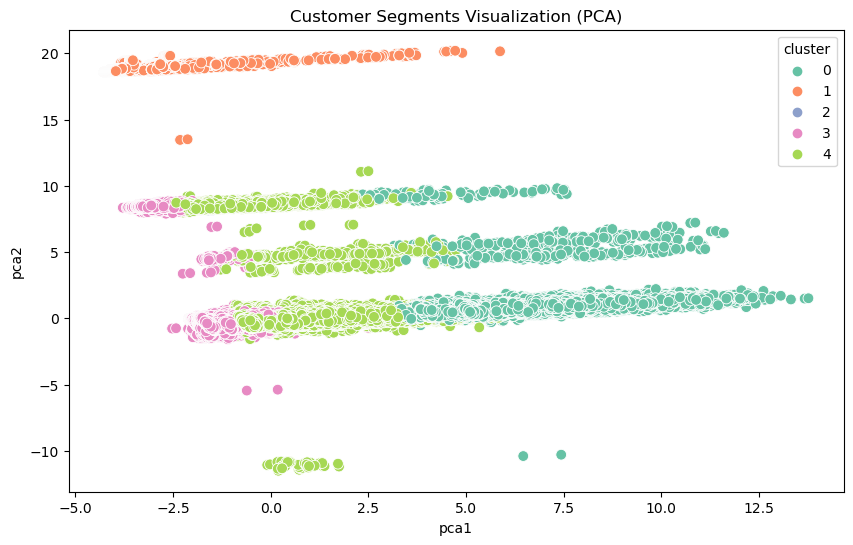

In [57]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled_df)
data['pca1'] = pca_result[:,0]
data['pca2'] = pca_result[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=data, palette='Set2', s=60)
plt.title("Customer Segments Visualization (PCA)")
plt.show()

In [58]:
for i in range(5):
    print(f"\nCluster {i} Profile:")
    cluster_data = data_model[data_model['cluster']==i]
    print("Number of customers:", cluster_data.shape[0])
    print("Average Age:", cluster_data['age'].mean())
    print("Average Income:", cluster_data['renta'].mean())
    print("Average Total Products:", cluster_data['total_products'].mean())
    top_products = cluster_data[product_cols].sum().sort_values(ascending=False).head(5)
    print("Top 5 Popular Products:\n", top_products)


Cluster 0 Profile:
Number of customers: 88629
Average Age: 47.04296562073362
Average Income: 150753.5739390144
Average Total Products: 5.877557007300093
Top 5 Popular Products:
 ind_cno_fin_ult1     84393.0
ind_nom_pens_ult1    77921.0
ind_recibo_ult1      73849.0
ind_nomina_ult1      70921.0
ind_ecue_fin_ult1    39822.0
dtype: float64

Cluster 1 Profile:
Number of customers: 10784
Average Age: 43.000370919881306
Average Income: 106651.86000000464
Average Total Products: 1.0022255192878338
Top 5 Popular Products:
 ind_cco_fin_ult1     3471.0
ind_reca_fin_ult1    3187.0
ind_ctop_fin_ult1     787.0
ind_ecue_fin_ult1     602.0
ind_pres_fin_ult1     537.0
dtype: float64

Cluster 2 Profile:
Number of customers: 2
Average Age: 57.0
Average Income: 106651.86000000002
Average Total Products: 2.0
Top 5 Popular Products:
 ind_cco_fin_ult1     2.0
ind_ctop_fin_ult1    2.0
ind_ahor_fin_ult1    0.0
ind_fond_fin_ult1    0.0
ind_nom_pens_ult1    0.0
dtype: float64

Cluster 3 Profile:
Number of custo

In [59]:
output_path = r"C:\Users\ASUS\Downloads\customer_clusters.csv"
data[['ncodpers','cluster']].to_csv(output_path, index=False)
print(f"\nClustered data saved to {output_path}")


Clustered data saved to C:\Users\ASUS\Downloads\customer_clusters.csv
